In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

from func import (
    source_seq,
    generate_square_mask,
    generate_pupil,
    generate_Ein,
    fourier_transform,
    inv_fourier_transform,
    shift2D,
    shift2Dinv,
    T_sigmoid,
    FR_sigmoid, 
    SD_optimization
)

plt.style.use(['science', 'ieee', 'no-latex'])

In [6]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
R = NA / np.float64(LAMBDA) # 0.003467741935483871
W = 200
THESHOLD = 0.5

In [7]:
f_max, samp1side = 0.05, 50
d_f = f_max / samp1side
s_max = 1 / (2 * d_f)
d_s = s_max / samp1side

In [8]:
s_seq, f_seq, sources = source_seq(s_max, f_max, samp1side, 1)
xx_space, yy_space = np.meshgrid(s_seq, s_seq)
xx_freq, yy_freq = np.meshgrid(f_seq, f_seq)
# sources
freq_pair = list(zip(xx_freq.flatten(), yy_freq.flatten()))
# I_dist
r, c = xx_space.flatten().shape[0], xx_freq.flatten().shape[0]
I_dist = np.zeros(shape=(r, c))

In [9]:
square_mask = generate_square_mask(s_seq, W)
pupil = generate_pupil(xx_freq, yy_freq, R)
square_mask.shape

(101, 101)

In [10]:
cnt = 0
for sinx, siny in freq_pair:
    # generate 2D Ein
    E_in = generate_Ein(K, xx_space, sinx, yy_space, siny)
    # Ein and the mask
    E_in_mask = E_in * square_mask
    # get E_out_unshift
    E_out_unshift = fourier_transform(E_in_mask)
    # E_out_pupil
    E_out_shift = shift2D(E_out_unshift)
    # E_out_pupil
    E_out_pupil = E_out_shift * pupil
    # E_out_pupil_unshift
    E_out_pupil_unshift = shift2Dinv(E_out_pupil)
    # get I
    I = inv_fourier_transform(E_out_pupil_unshift)
    I_abs = np.abs(I) ** 2
    I_abs_colv = I_abs.flatten()
    # put into I_dist
    I_dist[:, cnt] = I_abs_colv
    # add 1 for increase the index number of column
    cnt += 1

In [11]:
open_source = np.ones(shape=(I_dist.shape[1]))
normalize = open_source.shape[0]
I_out = np.dot(I_dist, open_source) / normalize

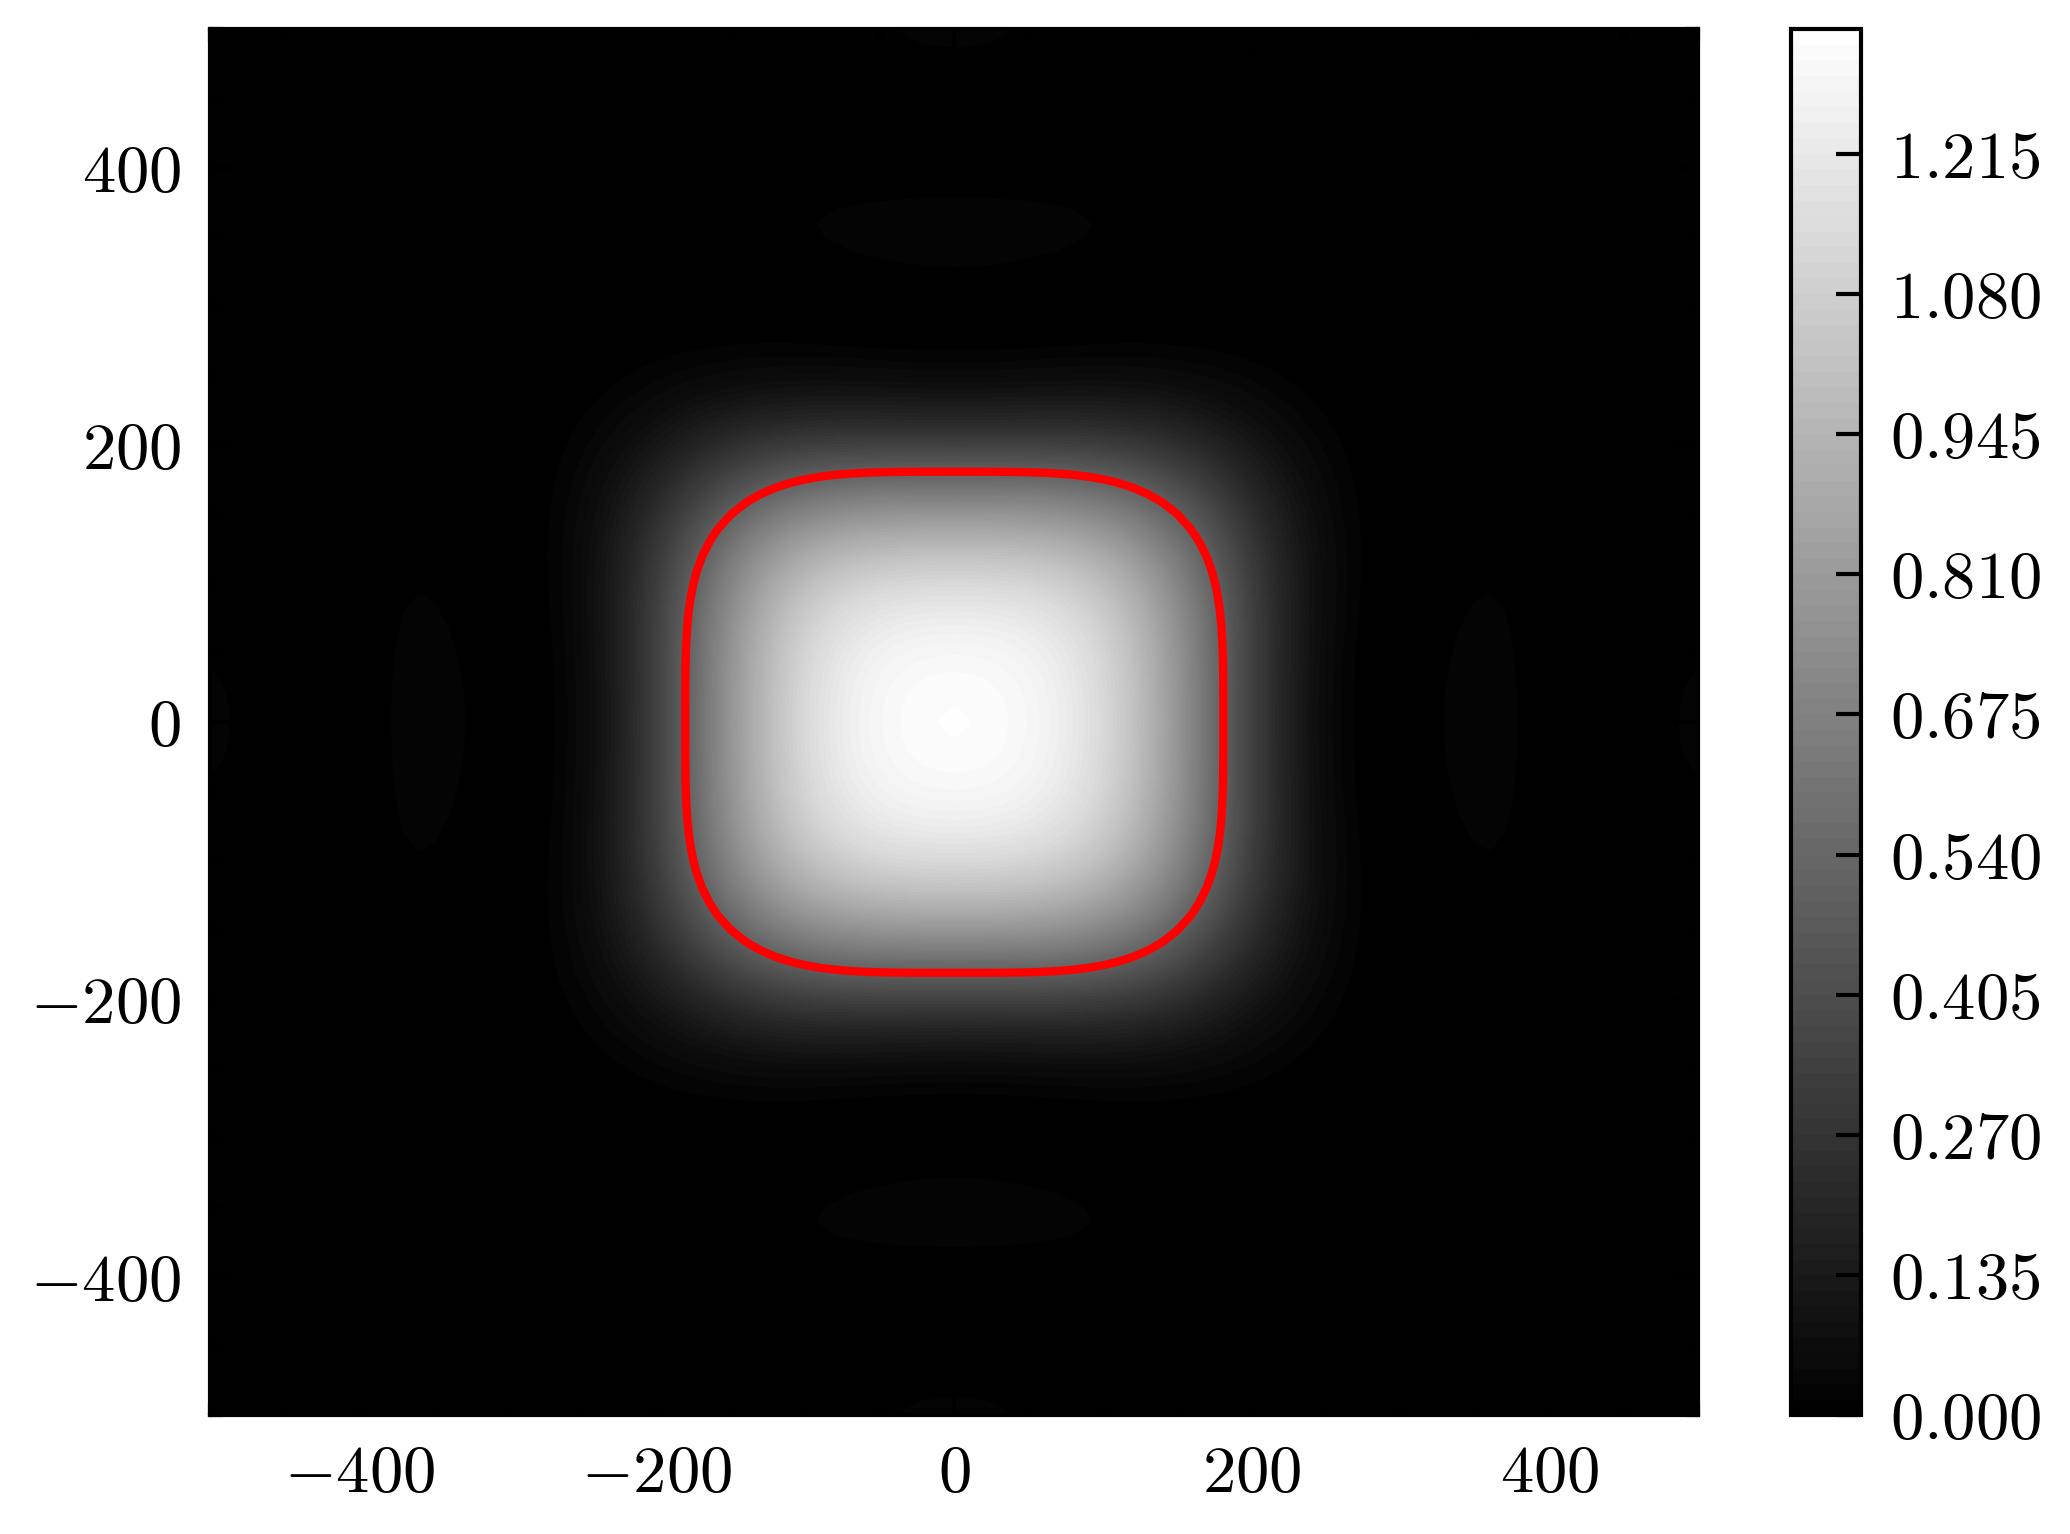

In [12]:
I_out_dist_2D = np.reshape(I_out, xx_space.shape)
plt.figure(figsize=(4, 3))
plt.contourf(xx_space, yy_space, I_out_dist_2D, cmap='gray', levels=100, zorder=0)
plt.colorbar()
plt.contour(xx_space, yy_space, I_out_dist_2D, levels=[0, 0.5], colors='red', zorder=0)

In [13]:
J = np.ones_like(open_source)
TIt = T_sigmoid(THESHOLD, square_mask)
gamma, alpha = 5, np.exp(-0.5)
J_opt, loss = SD_optimization(
    THESHOLD, I_dist, TIt, J, 90,
    T_sigmoid, FR_sigmoid,
    gamma, alpha
)

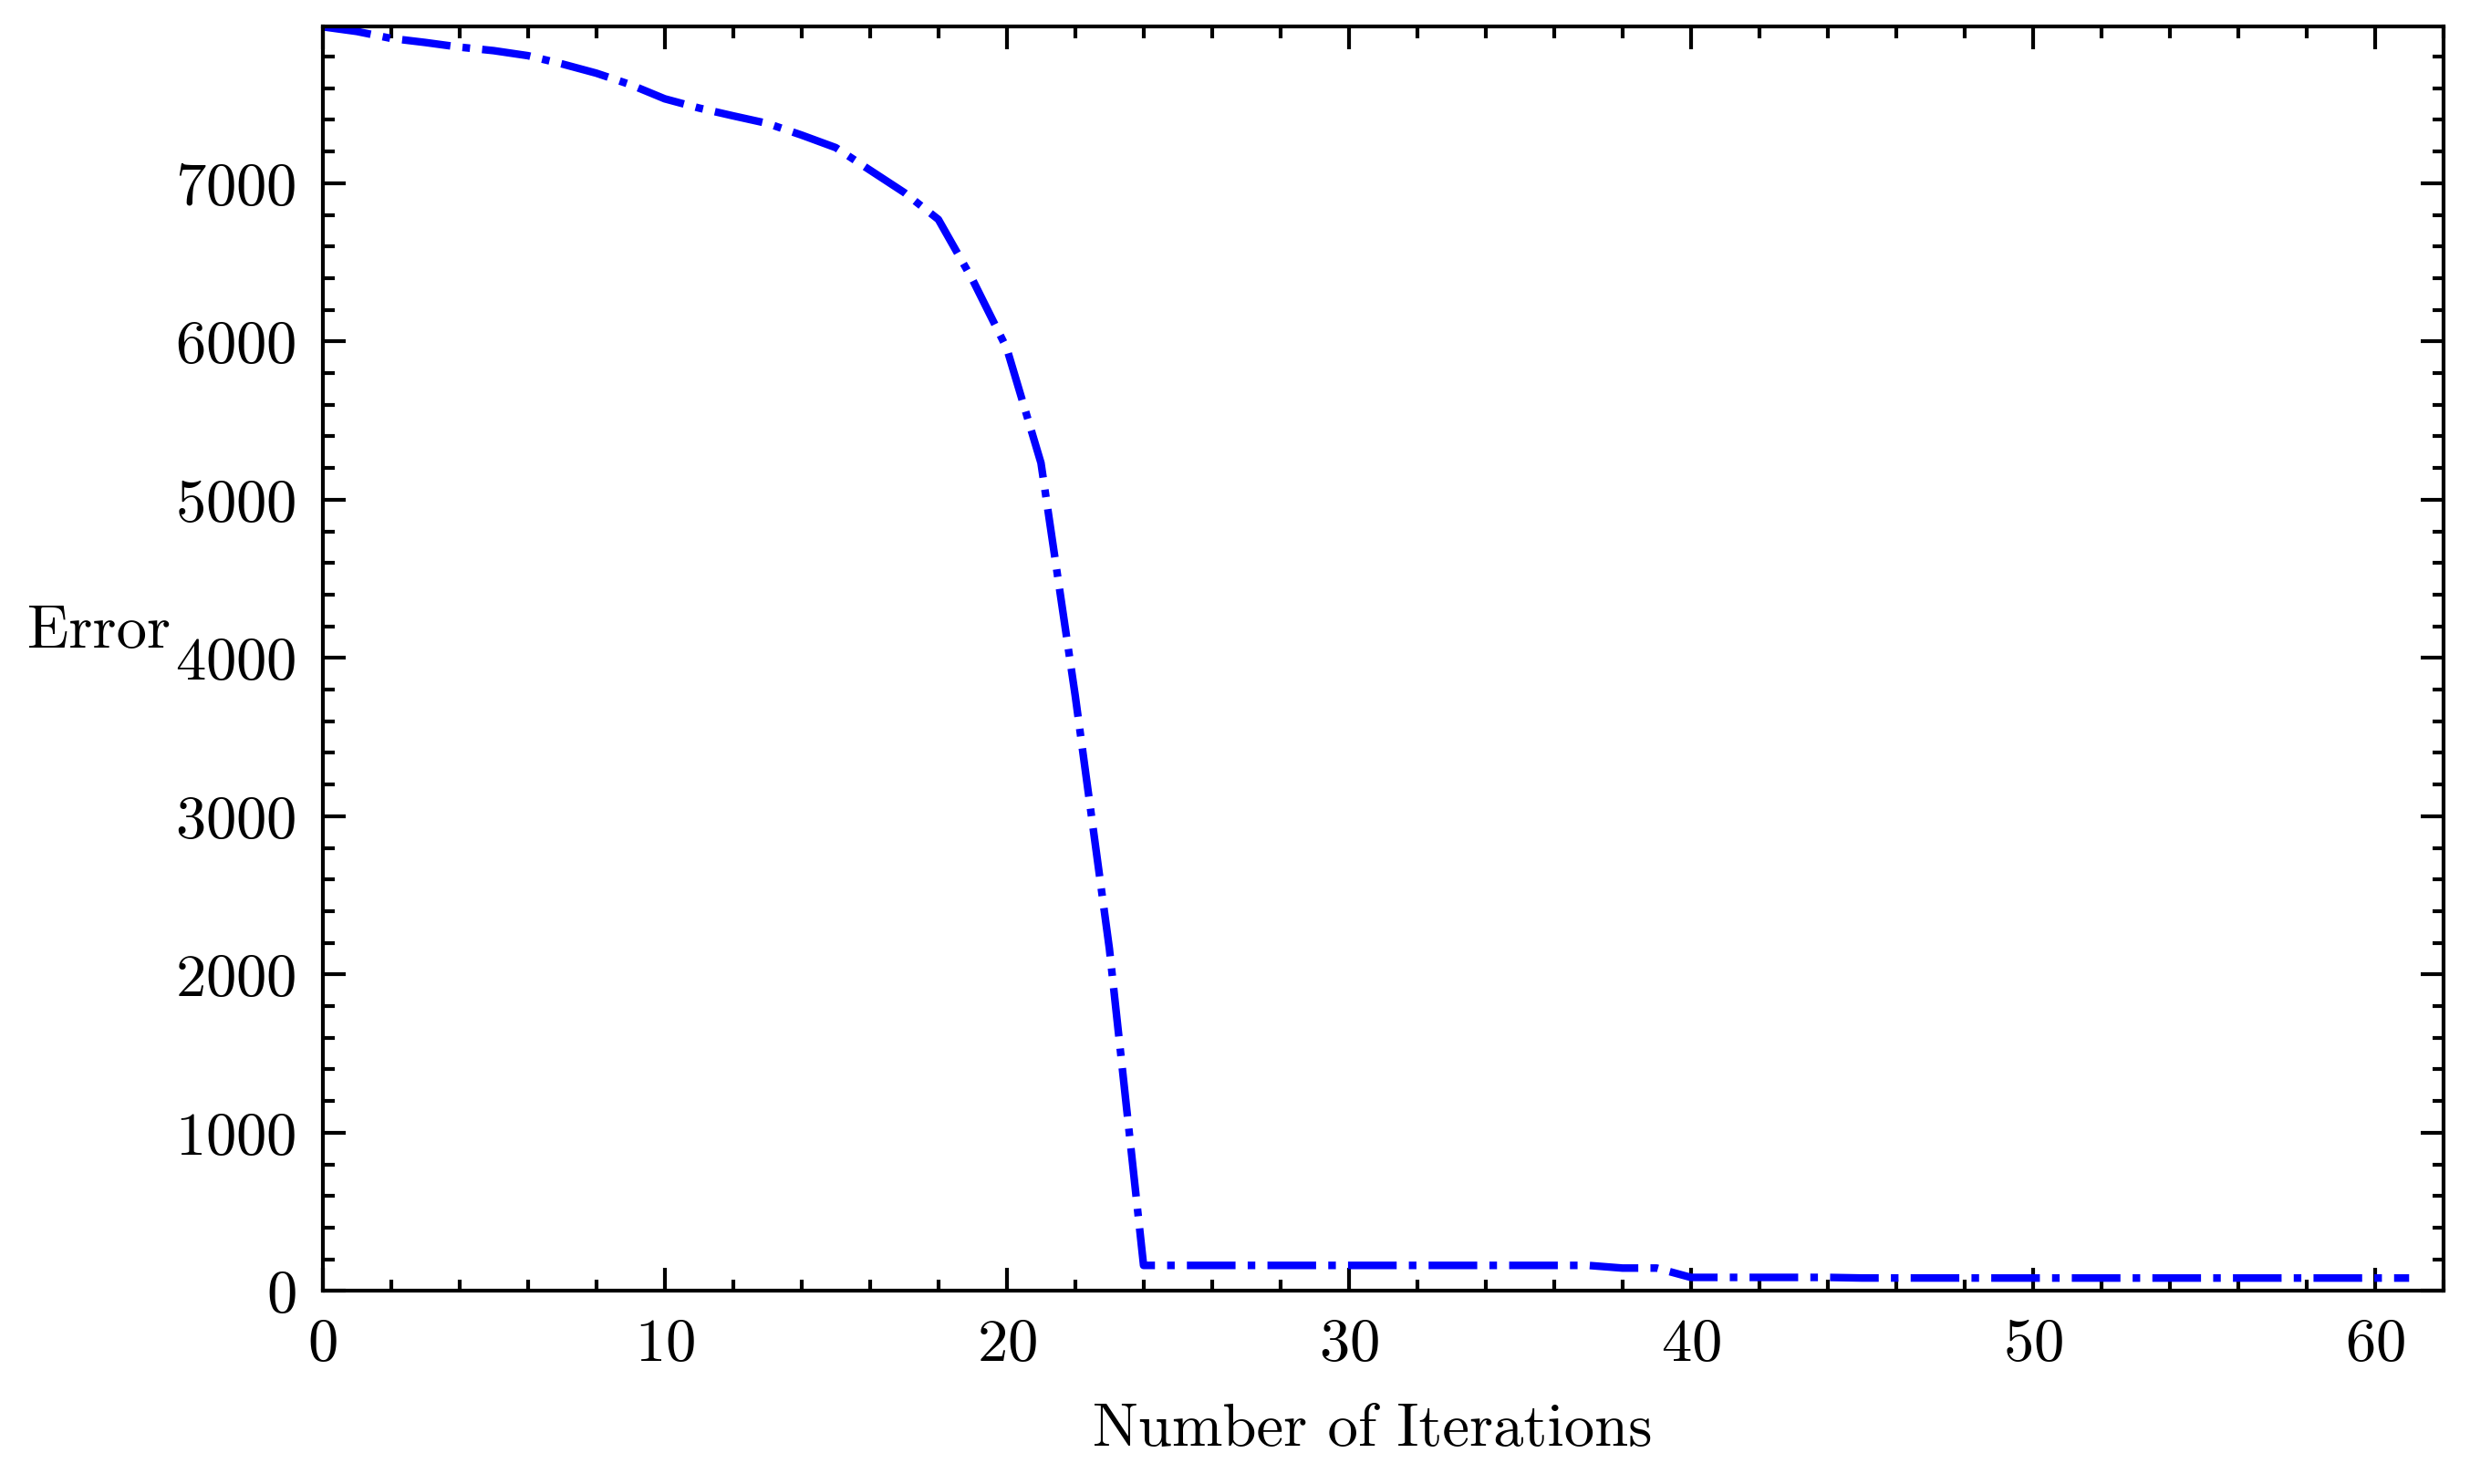

In [14]:
plt.figure(figsize=(5, 3))
plt.xlabel('Number of Iterations ')
plt.ylim(0, max(loss))
plt.xlim(0, len(loss))
plt.ylabel('Error', labelpad=10, rotation=0)
plt.plot(loss, 'b-.')

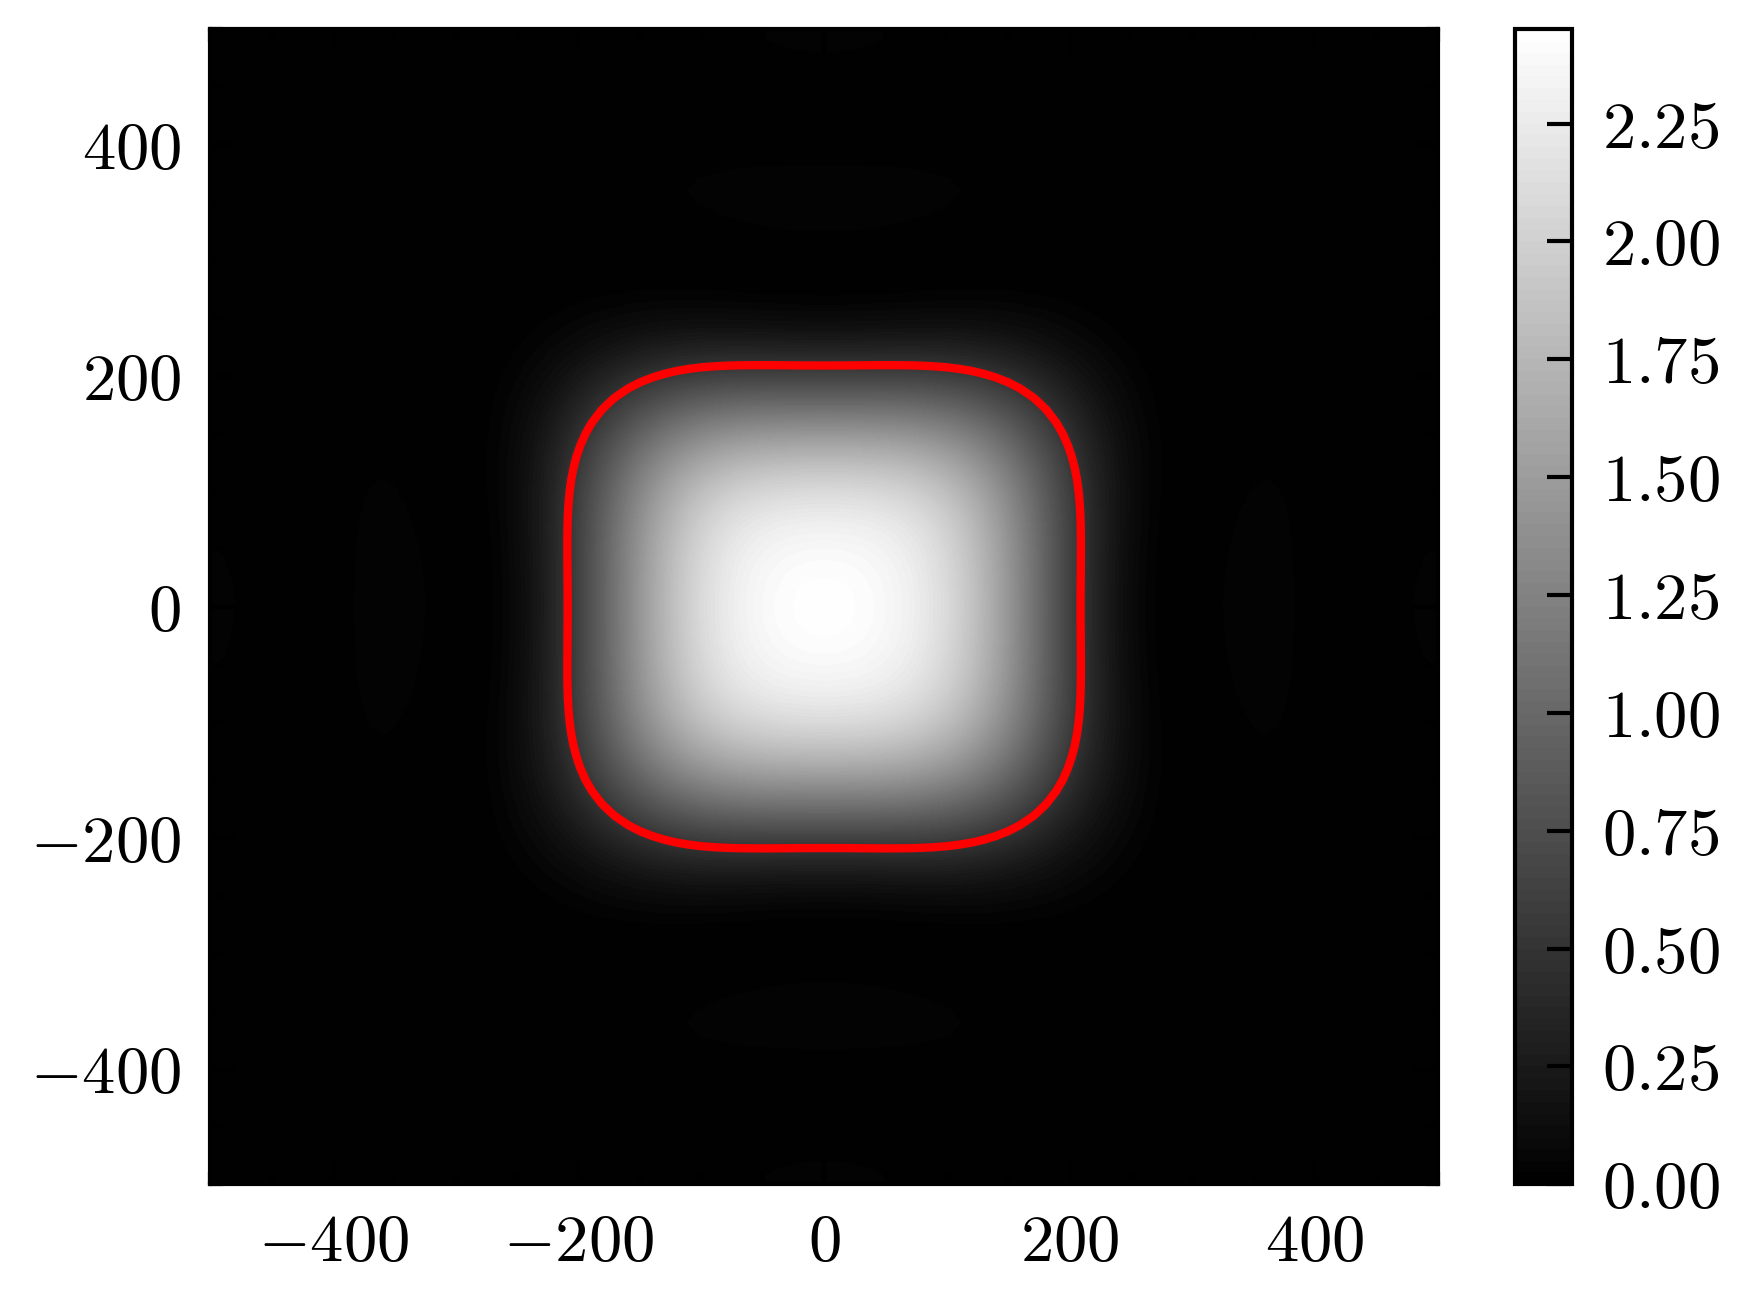

In [15]:
I_out = np.dot(I_dist, J_opt)
I_out_dist_2D_final = np.reshape(I_out, xx_space.shape)
plt.contourf(xx_space, yy_space, I_out_dist_2D_final, cmap='gray', levels=100)
plt.colorbar()
plt.contour(xx_space, yy_space, I_out_dist_2D_final, levels=[0, 0.5], colors='red')

In [16]:
CD_normalized_left = np.min(s_seq[I_out_dist_2D[samp1side] >= THESHOLD])
CD_normalized_right = np.max(s_seq[I_out_dist_2D[samp1side] >= THESHOLD])
CD_optimized_left = np.min(s_seq[I_out_dist_2D_final[samp1side] >= THESHOLD])
CD_optimized_right = np.max(s_seq[I_out_dist_2D_final[samp1side] >= THESHOLD])

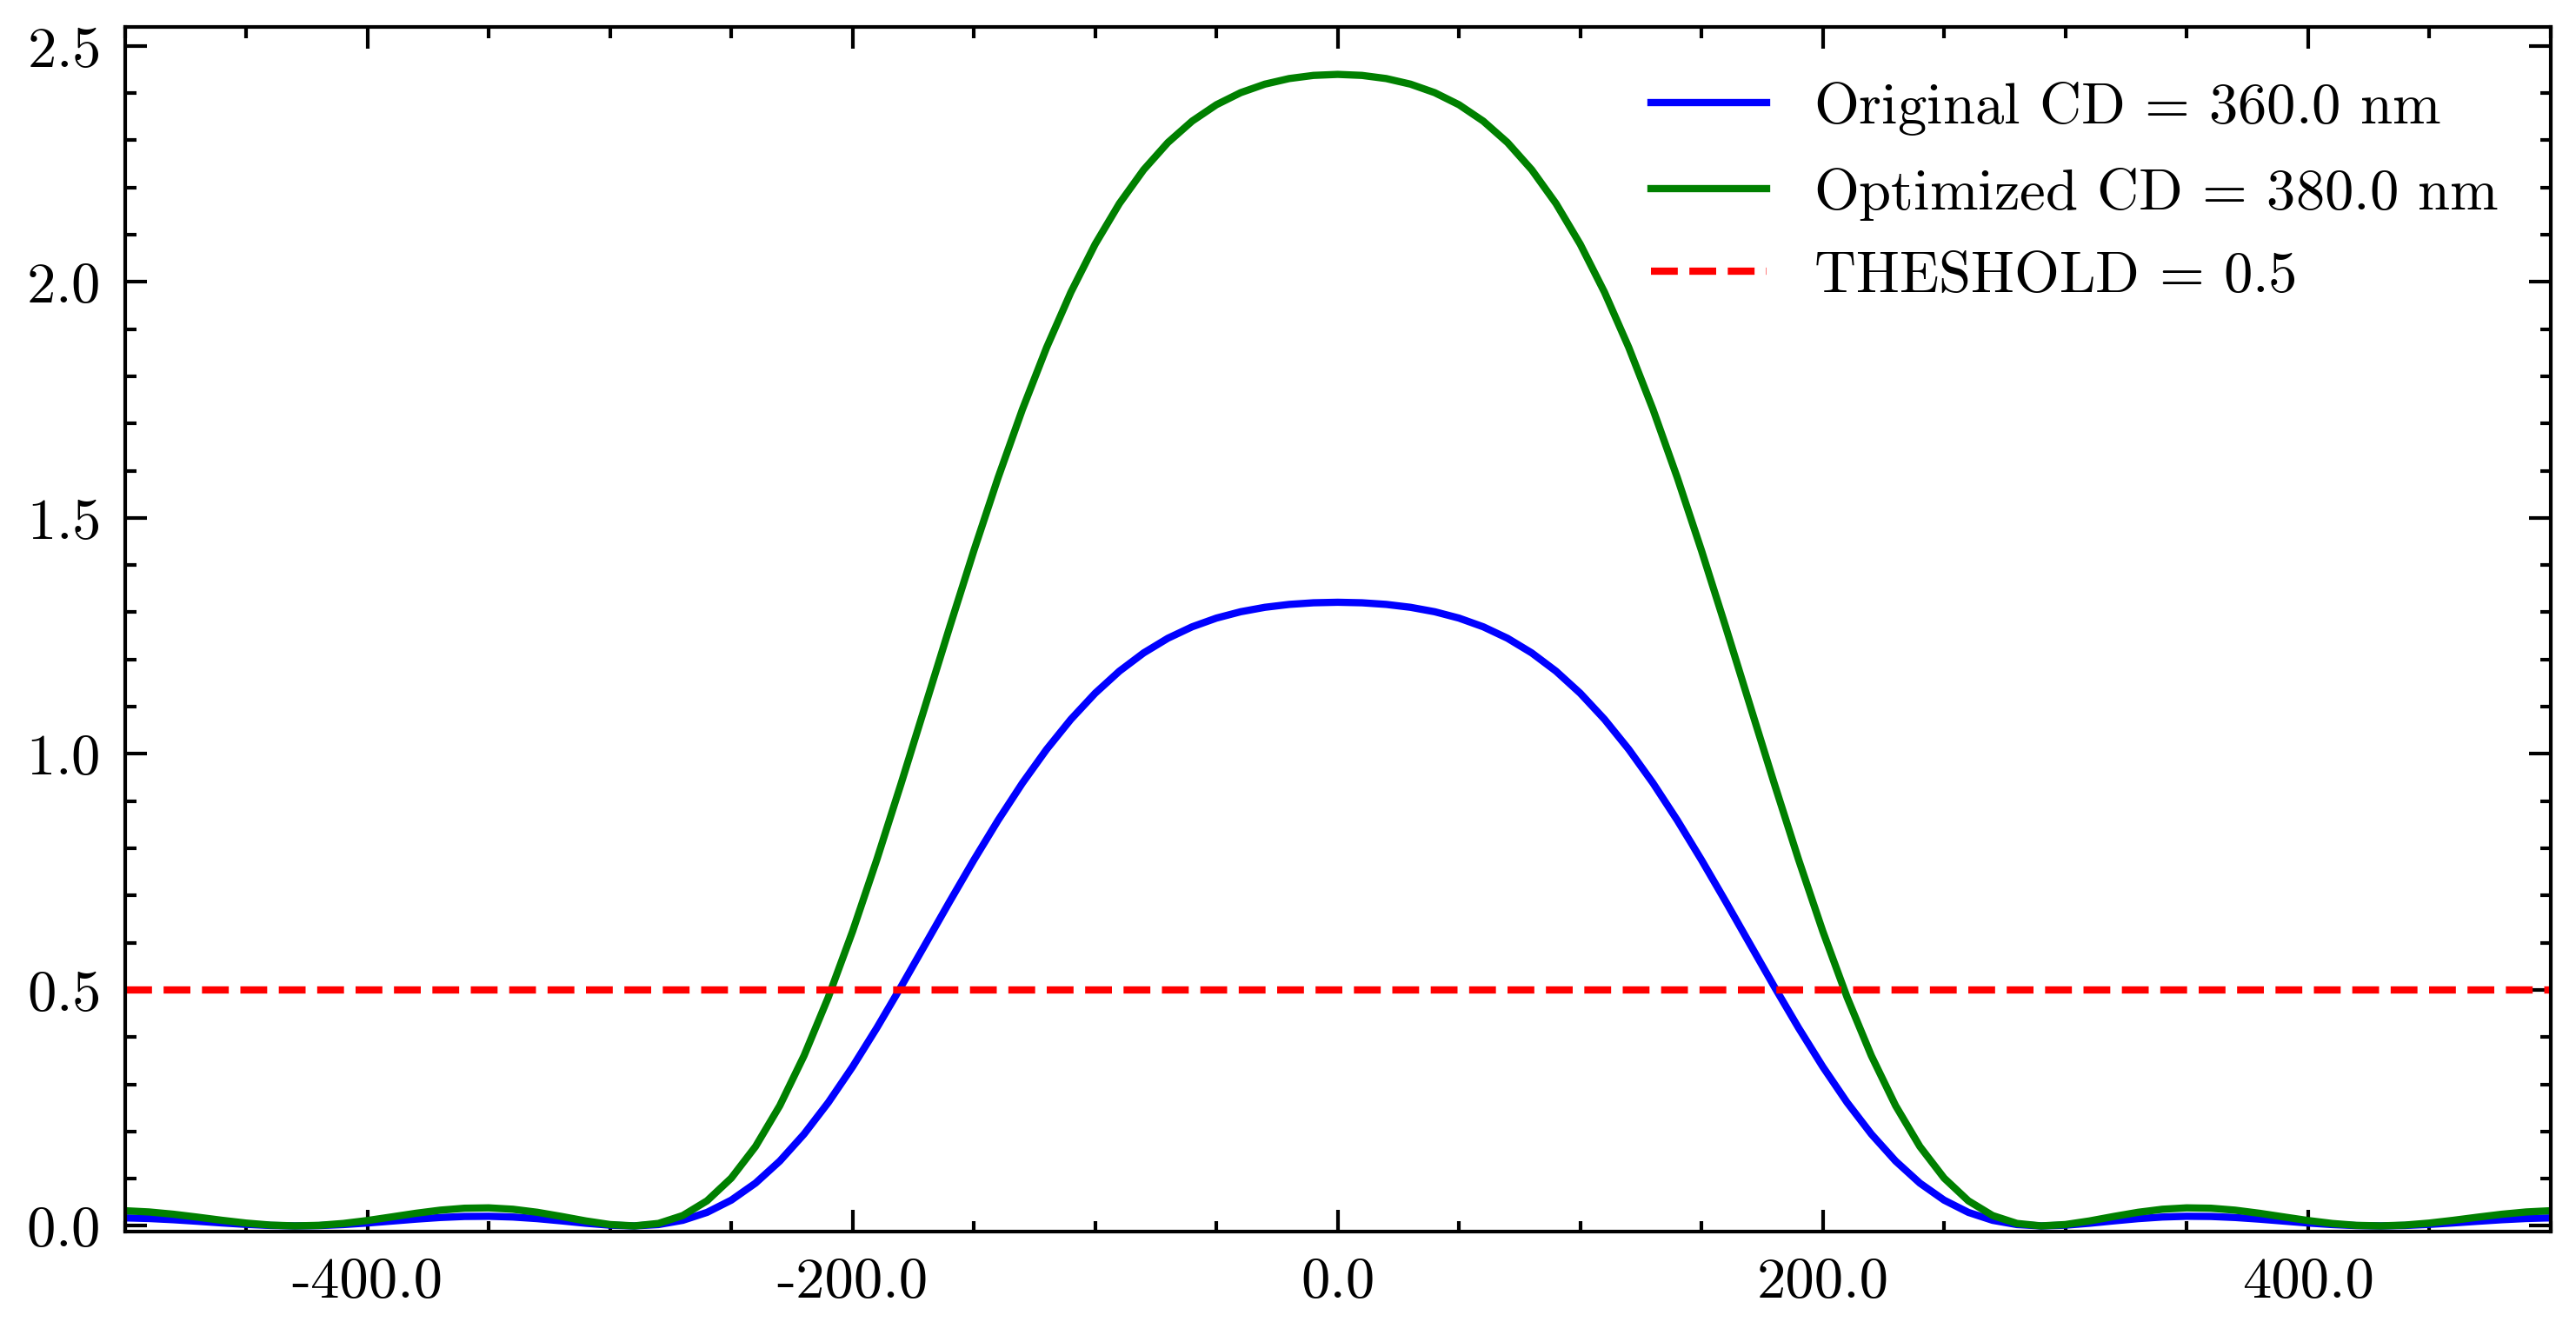

In [17]:
plt.figure(figsize=(6, 3))
plt.xlim(0, 2 * samp1side)
plt.ylim(-0.0125, np.max(I_out_dist_2D_final) + 0.1)
d_n = W // d_s
old_x = [samp1side]
l = r = samp1side
while 1:
    if l - d_n < 0 and r + d_n > 2 *samp1side:
        break
    if l - d_n >= 0: 
        old_x.append(l - d_n)
    if r + d_n <= 2 * samp1side:
        old_x.append(r + d_n)
    l -= d_n
    r += d_n    
old_x.sort()
old_x = [int(elem) for elem in old_x]
new_x = s_seq[old_x]
plt.xticks(old_x, new_x)
# plt.plot(square_mask[samp1side, :], 'r--', label='')
plt.plot(I_out_dist_2D[samp1side, :], 'b-', label=f'Original CD = ${CD_normalized_right - CD_normalized_left}$ nm')
plt.plot(I_out_dist_2D_final[samp1side, :], 'g-', label=f'Optimized CD = ${CD_optimized_right - CD_normalized_left}$ nm')
plt.axhline([0.5], color='red', linestyle='--', label=f'THESHOLD = $0.5$')
plt.legend()